In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve, accuracy_score, roc_auc_score, roc_curve

from yellowbrick.model_selection import LearningCurve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pickle

In [2]:
lda_df = pd.read_csv('df_lda.csv')

In [3]:
# Filling NaN values with 0, because its a our webscrapping source, when these values do not occur,  the site does not show the output so it can be adopted as a zero value.
def func(x):
    """
    Applying a function that change values of a Draw Match to 0, when Home team won to 1 and Away team won to -1.
    """
    if x == 'Draw':
        return 0
    elif x == 'Home':
        return 1
    else:
        return -1

def apply_func(dataframe, column):
    dataframe[column] = dataframe[column].apply(func)       

In [4]:
apply_func(lda_df, 'result')

In [5]:
le = preprocessing.LabelEncoder()
lda_df[['team_home','team_away']] = lda_df[['team_home','team_away']].apply(le.fit_transform)

# Model - Random Forest

In [6]:
# Defining X and Y

X = lda_df.drop('result', axis=1)
y = lda_df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [7]:
# Random Forest Parameters to optimize:
                                                       # Parameters explained:
param_grid = {'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10],         # The number of trees in the forest.
              'criterion': ['gini', 'entropy'],        # The function to measure the quality of a split.
              'max_features': ['auto', 'sqrt'],        # The number of features to consider when looking for the best split
              'max_depth': [1, 2, 3, 4, 5, None], # The maximum depth of the tree.
              'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8],         # The minimum number of samples required to split an internal node
              'min_samples_leaf': [8, 9, 10, 11, 12, 13],           # The minimum number of samples required to be at a leaf node.
              'bootstrap': [True, False]}              # Whether bootstrap samples are used when building trees.

In [ ]:
gsearch = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
random_model = gsearch.fit(X_train, y_train)

# Best params by the best score

print(random_model.best_params_, random_model.best_score_)

In [8]:
model = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_depth = 2,
                               max_features = 'auto', min_samples_leaf = 10, 
                               min_samples_split = 5, n_estimators = 4, random_state=42,n_jobs=-1)

In [9]:
pipeline = Pipeline(steps=[('model', model)])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=2, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=4, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [11]:
pipeline.predict(X_test)

array([ 1,  0, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1], dtype=int64)

In [12]:
pipeline.score(X_test, y_test)

0.3829787234042553

In [13]:
roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class='ovr')

0.45367622524485274

In [14]:
precision_score(y_test, pipeline.predict(X_test), average='weighted')

0.2895136778115502

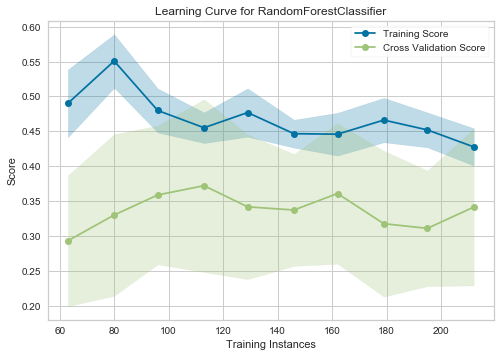

In [15]:
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

visualizer = LearningCurve(
    pipeline, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

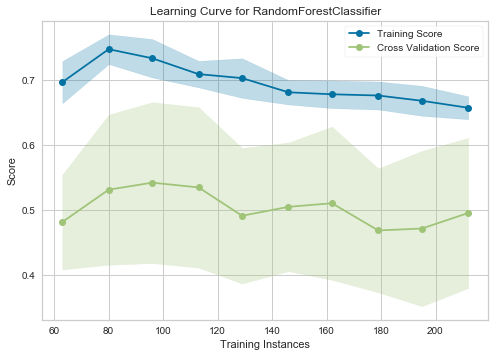

In [16]:
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

visualizer = LearningCurve(
    pipeline, cv=cv, scoring='roc_auc_ovr', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

# Exporting Pipeline

In [17]:
pickle.dump( pipeline, open( "ldamod.p", "wb" ) )

In [18]:
pipeline.predict(X)

array([ 1, -1,  1,  1,  0,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        1,  0, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  0, -1,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1, -1,  0, -1,  1,  1, -1,  1, -1,
        1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,
       -1,  1, -1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1, -1,  1,  0,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  0,  1,
        1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  0,  1,  1, -1,  1,
        1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1, -1,  1,  1

In [19]:
lda_df.head(1)

,team_home,result,labels_0_home,labels_1_home,labels_2_home,labels_3_home,labels_4_home,labels_5_home,labels_6_home,labels_7_home,team_away,labels_0_away,labels_1_away,labels_2_away,labels_3_away,labels_4_away,labels_5_away,labels_6_away,labels_7_away
0,1,1,0,4,6,0,5,8,2,3,13,5,3,0,4,13,7,4,1


In [20]:
df = pd.read_csv('df_lda.csv')
df['predict_comments']=pipeline.predict(X)
df['proba_home']=pipeline.predict_proba(X)[:,2]
df['proba_draw']=pipeline.predict_proba(X)[:,1]
df['proba_away']=pipeline.predict_proba(X)[:,0]
df.to_csv('../stack/nlp_results.csv', index=False)

